Import libraries and read in the turnstiles dataset, using SQLalchemy.

In [15]:
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
%matplotlib inline

engine = create_engine("sqlite:////Users/emmaalexander/Desktop/NBM_EDA_Student/mta_data.db")
insp = inspect(engine)
print(insp.get_table_names())

['mta_data']


In [75]:
turnstiles_df = pd.read_sql('SELECT * FROM mta_data WHERE DATE BETWEEN "09/01/2019" AND "11/30/2019" AND STATION IS NOT NULL', engine)
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676233 entries, 0 to 2676232
Data columns (total 11 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   C/A       object
 1   UNIT      object
 2   SCP       object
 3   STATION   object
 4   LINENAME  object
 5   DIVISION  object
 6   DATE      object
 7   TIME      object
 8   DESC      object
 9   ENTRIES   int64 
 10  EXITS     int64 
dtypes: int64(2), object(9)
memory usage: 224.6+ MB


Let's see what the average entry numbers are for each station per day in September, to get a sense of the data. (It's not going to be accurate, yet, because the entry data is cumulative - we'll deal with that later using pandas.)

In [331]:
average_traffic = pd.read_sql('SELECT STATION, AVG(SUM) AS "DAILY AVERAGE" FROM (SELECT *, SUM(ENTRIES) AS "SUM" FROM mta_data GROUP BY STATION,"C/A",UNIT, SCP,DATE HAVING DATE BETWEEN "09/01/2019" AND "09/30/2019")GROUP BY STATION ORDER BY AVG(ENTRIES) DESC', engine)
average_traffic.head(10)

,STATION,DAILY AVERAGE
0,183 ST,6.907415e+09
1,BAYCHESTER AV,4.145346e+09
2,225 ST,3.922964e+09
3,104 ST,3.238861e+09
4,3 AV 138 ST,3.089804e+09
5,182-183 STS,2.981947e+09
6,190 ST,2.907726e+09
7,HIGH ST,2.752835e+09
8,EASTCHSTER/DYRE,2.533665e+09
9,138/GRAND CONC,1.999901e+09


Clean up column names.

In [78]:
turnstiles_df.columns = turnstiles_df.columns.str.replace(" ","")
turnstiles_df.columns = turnstiles_df.columns.str.replace("/","_")
turnstiles_df.columns = turnstiles_df.columns.str.lower()
turnstiles_df

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,03:00:00,REGULAR,7290785,2470635
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,07:00:00,REGULAR,7290795,2470652
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,11:00:00,REGULAR,7290860,2470733
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,15:00:00,REGULAR,7291051,2470808
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,11/30/2019,19:00:00,REGULAR,7291396,2470862
...,...,...,...,...,...,...,...,...,...,...,...
2676228,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/06/2019,05:00:00,REGULAR,5554,420
2676229,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/06/2019,09:00:00,REGULAR,5554,420
2676230,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/06/2019,13:00:00,REGULAR,5554,420
2676231,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,09/06/2019,17:00:00,REGULAR,5554,420


Standardize the station column as much as possible, for future merging with complaints dataset.

In [80]:
turnstiles_df['station'] = turnstiles_df['station'].str.replace('AVENUE','AV', regex=False)
turnstiles_df['station'] = turnstiles_df['station'].str.replace('AVE','AV', regex=False)
turnstiles_df['station'] = turnstiles_df['station'].str.replace('.','', regex=False)
turnstiles_df['station'] = turnstiles_df['station'].str.replace(' ROAD',' RD', regex=False)

Convert "date" column to datetime dtype.

In [81]:
turnstiles_df['date'] = pd.to_datetime(turnstiles_df['date'])
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2676233 entries, 0 to 2676232
Data columns (total 11 columns):
 #   Column    Dtype         
---  ------    -----         
 0   c_a       object        
 1   unit      object        
 2   scp       object        
 3   station   object        
 4   linename  object        
 5   division  object        
 6   date      datetime64[ns]
 7   time      object        
 8   desc      object        
 9   entries   int64         
 10  exits     int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 224.6+ MB


Taking a look at all the unique station names in the turnstiles dataset, since we'll need to merge this with the stations in the complaints dataset.

In [82]:
station_array = turnstiles_df['station'].unique()
station_array.sort()
station_array

array(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST', '111 ST',
       '116 ST', '116 ST-COLUMBIA', '121 ST', '125 ST', '135 ST',
       '137 ST CITY COL', '138/GRAND CONC', '14 ST', '14 ST-UNION SQ',
       '145 ST', '149/GRAND CONC', '14TH STREET', '15 ST-PROSPECT',
       '155 ST', '157 ST', '161/YANKEE STAD', '163 ST-AMSTERDM', '167 ST',
       '168 ST', '169 ST', '170 ST', '174 ST', '174-175 STS', '175 ST',
       '176 ST', '18 AV', '18 ST', '181 ST', '182-183 STS', '183 ST',
       '190 ST', '191 ST', '2 AV', '20 AV', '207 ST', '21 ST',
       '21 ST-QNSBRIDGE', '215 ST', '219 ST', '225 ST', '23 ST', '231 ST',
       '233 ST', '238 ST', '25 AV', '25 ST', '28 ST', '3 AV',
       '3 AV 138 ST', '3 AV-149 ST', '30 AV', '33 ST', '33 ST-RAWSON ST',
       '34 ST-HERALD SQ', '34 ST-HUDSON YD', '34 ST-PENN STA', '36 AV',
       '36 ST', '39 AV', '4 AV-9 ST', '40 ST LOWERY ST',
       '42 ST-BRYANT PK', '42 ST-PORT AUTH', '45 ST', '46 ST',
       '46 ST BLISS ST', '47-50 STS ROCK

Reading in the complaints dataset. 

In [83]:
complaints = pd.read_csv("https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv")
complaints.head()

/Users/emmaalexander/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,394506329,12/31/2019,17:30:00,NaN,NaN,32.0,12/31/2019,118,DANGEROUS WEAPONS,793.0,...,NaN,NaN,40.820927,-73.943324,"(40.82092679700002, -73.94332421899996)",PATROL BORO MAN NORTH,NaN,UNKNOWN,UNKNOWN,E
1,968873685,12/29/2019,16:31:00,12/29/2019,16:54:00,47.0,12/29/2019,113,FORGERY,729.0,...,NaN,NaN,40.885701,-73.861640,"(40.885701406000074, -73.86164032499995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
2,509837549,12/15/2019,18:45:00,NaN,NaN,109.0,12/29/2019,578,HARRASSMENT 2,638.0,...,M,NaN,40.742281,-73.819824,"(40.74228115600005, -73.81982408)",PATROL BORO QUEENS NORTH,NaN,25-44,WHITE HISPANIC,F
3,352454313,12/28/2019,01:00:00,NaN,NaN,47.0,12/28/2019,126,MISCELLANEOUS PENAL LAW,117.0,...,M,NaN,40.875311,-73.847545,"(40.87531145100007, -73.84754521099995)",PATROL BORO BRONX,NaN,UNKNOWN,UNKNOWN,E
4,248803469,09/05/2008,21:41:00,NaN,NaN,NaN,09/05/2008,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,NaN,NaN,40.698827,-73.938819,"(40.698827283, -73.938819047)",NaN,NaN,25-44,BLACK,M


Since the dataset is for NYC generally, I'll need to narrow it down to complaints logged at MTA stations. I'm dropping all rows that don't have values for station name, victim sex, and date of complaint.

In [84]:
complaints_station = complaints.dropna(subset=['STATION_NAME','CMPLNT_FR_DT','VIC_SEX'])
complaints_station.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
253,132630637,10/02/2019,15:49:00,NaN,NaN,44.0,10/02/2019,109,GRAND LARCENY,415.0,...,NaN,11.0,40.838752,-73.913758,"(40.838751870000074, -73.91375755599995)",PATROL BORO BRONX,170 STREET,25-44,BLACK,F
1169,875328878,12/25/2019,19:30:00,12/25/2019,20:45:00,106.0,12/25/2019,109,GRAND LARCENY,439.0,...,NaN,23.0,40.660514,-73.830588,"(40.66051428600008, -73.83058757999999)",PATROL BORO QUEENS SOUTH,HOWARD BEACH-JFK AIRPORT,<18,WHITE,M
1170,476108355,12/10/2019,15:00:00,12/10/2019,15:02:00,14.0,12/27/2019,343,THEFT OF SERVICES,475.0,...,NaN,2.0,40.748298,-73.988178,"(40.74829799100007, -73.98817814399997)",PATROL BORO MAN SOUTH,34 STREET,UNKNOWN,UNKNOWN,E
1207,464842359,12/30/2019,18:50:00,NaN,NaN,13.0,12/30/2019,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,4.0,40.741365,-73.989128,"(40.74136484500008, -73.98912845999998)",PATROL BORO MAN SOUTH,23 STREET,25-44,WHITE,M
1234,816752208,12/17/2019,23:54:00,12/18/2019,00:54:00,75.0,12/30/2019,355,OFFENSES AGAINST THE PERSON,115.0,...,U,33.0,40.676337,-73.865464,"(40.676337363000066, -73.86546353999995)",PATROL BORO BKLYN NORTH,GRANT AVENUE,UNKNOWN,UNKNOWN,E


In [85]:
complaints_station.shape

(163485, 35)

Making the column names lowercase.

In [347]:
complaints_station.columns = complaints_station.columns.str.lower()
complaints_station.head()

,cmplnt_num,cmplnt_fr_dt,cmplnt_fr_tm,cmplnt_to_dt,cmplnt_to_tm,addr_pct_cd,rpt_dt,ky_cd,ofns_desc,pd_cd,...,susp_sex,transit_district,latitude,longitude,lat_lon,patrol_boro,station_name,vic_age_group,vic_race,vic_sex
253,132630637,10/02/2019,15:49:00,NaN,NaN,44.0,10/02/2019,109,GRAND LARCENY,415.0,...,NaN,11.0,40.838752,-73.913758,"(40.838751870000074, -73.91375755599995)",PATROL BORO BRONX,170 STREET,25-44,BLACK,F
1169,875328878,12/25/2019,19:30:00,12/25/2019,20:45:00,106.0,12/25/2019,109,GRAND LARCENY,439.0,...,NaN,23.0,40.660514,-73.830588,"(40.66051428600008, -73.83058757999999)",PATROL BORO QUEENS SOUTH,HOWARD BEACH-JFK AIRPORT,<18,WHITE,M
1170,476108355,12/10/2019,15:00:00,12/10/2019,15:02:00,14.0,12/27/2019,343,THEFT OF SERVICES,475.0,...,NaN,2.0,40.748298,-73.988178,"(40.74829799100007, -73.98817814399997)",PATROL BORO MAN SOUTH,34 STREET,UNKNOWN,UNKNOWN,E
1207,464842359,12/30/2019,18:50:00,NaN,NaN,13.0,12/30/2019,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,4.0,40.741365,-73.989128,"(40.74136484500008, -73.98912845999998)",PATROL BORO MAN SOUTH,23 STREET,25-44,WHITE,M
1234,816752208,12/17/2019,23:54:00,12/18/2019,00:54:00,75.0,12/30/2019,355,OFFENSES AGAINST THE PERSON,115.0,...,U,33.0,40.676337,-73.865464,"(40.676337363000066, -73.86546353999995)",PATROL BORO BKLYN NORTH,GRANT AVENUE,UNKNOWN,UNKNOWN,E


In [348]:
complaints_station.columns

Index(['cmplnt_num', 'cmplnt_fr_dt', 'cmplnt_fr_tm', 'cmplnt_to_dt',
       'cmplnt_to_tm', 'addr_pct_cd', 'rpt_dt', 'ky_cd', 'ofns_desc', 'pd_cd',
       'pd_desc', 'crm_atpt_cptd_cd', 'law_cat_cd', 'boro_nm',
       'loc_of_occur_desc', 'prem_typ_desc', 'juris_desc', 'jurisdiction_code',
       'parks_nm', 'hadevelopt', 'housing_psa', 'x_coord_cd', 'y_coord_cd',
       'susp_age_group', 'susp_race', 'susp_sex', 'transit_district',
       'latitude', 'longitude', 'lat_lon', 'patrol_boro', 'station_name',
       'vic_age_group', 'vic_race', 'vic_sex'],
      dtype='object')

Making a new dataframe with only the columns I'm interested in.

In [349]:
comp_w= complaints_station[['cmplnt_fr_dt', 'cmplnt_fr_tm', 'ofns_desc', 'pd_desc', 'law_cat_cd', 'boro_nm', 'transit_district', 'station_name', 'vic_sex']]
comp_w.head()

,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,pd_desc,law_cat_cd,boro_nm,transit_district,station_name,vic_sex
253,10/02/2019,15:49:00,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,PICK",FELONY,BRONX,11.0,170 STREET,F
1169,12/25/2019,19:30:00,GRAND LARCENY,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",FELONY,QUEENS,23.0,HOWARD BEACH-JFK AIRPORT,M
1170,12/10/2019,15:00:00,THEFT OF SERVICES,UNAUTH. SALE OF TRANS. SERVICE,MISDEMEANOR,MANHATTAN,2.0,34 STREET,E
1207,12/30/2019,18:50:00,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,MISDEMEANOR,MANHATTAN,4.0,23 STREET,M
1234,12/17/2019,23:54:00,OFFENSES AGAINST THE PERSON,RECKLESS ENDANGERMENT 2,MISDEMEANOR,BROOKLYN,33.0,GRANT AVENUE,E


It looks like a bunch of district offices are logged along with the actual stations. Let's get rid of everything that doesn't look like a real station.

In [350]:
mask = (~comp_w['station_name'].str.contains('OFFICE'))

In [334]:
comp_w = comp_w[mask].copy()
comp_w

,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,pd_desc,law_cat_cd,boro_nm,transit_district,station_name,vic_sex
253,10/02/2019,15:49:00,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,PICK",FELONY,BRONX,11.0,170 STREET,F
1169,12/25/2019,19:30:00,GRAND LARCENY,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",FELONY,QUEENS,23.0,HOWARD BEACH-JFK AIRPORT,M
1170,12/10/2019,15:00:00,THEFT OF SERVICES,UNAUTH. SALE OF TRANS. SERVICE,MISDEMEANOR,MANHATTAN,2.0,34 STREET,E
1207,12/30/2019,18:50:00,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,MISDEMEANOR,MANHATTAN,4.0,23 STREET,M
1234,12/17/2019,23:54:00,OFFENSES AGAINST THE PERSON,RECKLESS ENDANGERMENT 2,MISDEMEANOR,BROOKLYN,33.0,GRANT AVENUE,E
...,...,...,...,...,...,...,...,...,...
7375805,09/19/2018,10:40:00,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",FELONY,MANHATTAN,4.0,116 STREET,E
7375823,12/10/2018,14:20:00,PETIT LARCENY,"LARCENY,PETIT BY FALSE PROMISE",MISDEMEANOR,BRONX,11.0,167 STREET,F
7375824,07/06/2018,14:10:00,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",FELONY,BRONX,11.0,205 ST.-NORWOOD,E
7375873,01/11/2018,15:30:00,FORGERY,"FORGERY,ETC.,UNCLASSIFIED-FELO",FELONY,BRONX,12.0,SIMPSON STREET,E


In [351]:
off_mask = comp_w['station_name'] != "OFF-SYSTEM"

In [352]:
comp_w = comp_w[off_mask].copy()

In [353]:
comp_w['station_name'].value_counts().tail(20)

HUNTERS POINT AVENUE    48
FOREST AVENUE           47
SENECA AVENUE           47
AVENUE "N"              47
55 STREET               45
AVENUE "P"              41
72ND STREET             39
21 STREET               38
86TH STREET             35
DISTRICT 32 OFFICE      31
DISTRICT 11 OFFICE      30
BEACH 105 STREET        30
DISTRICT 3 OFFICE       29
DISTRICT 2 OFFICE       27
DISTRICT 20 OFFICE      22
AQUEDUCT-RACETRACK      19
DISTRICT 12 OFFICE      18
DISTRICT 30 OFFICE      17
DISTRICT 34 OFFICE      13
DISTRICT 23 OFFICE       6
Name: station_name, dtype: int64

All non-stations are gone! Now, let's rename the station column to match the name in the turnstiles dataset, and clean up some incorrect dates. There are multiple instances where someone entered a "10" instead of a "20" when logging the year - 1010, 1011, etc.

In [354]:
comp_w.rename(columns={'station_name': 'station'}, inplace=True)

In [355]:
prev_date = ['10','11','12','13','14','15','16','17','18','19','20']
for date in prev_date:
    comp_w['cmplnt_fr_dt'] = comp_w['cmplnt_fr_dt'].str.replace('10' + date, '20' + date, regex=False)
comp_w['cmplnt_fr_dt'].sort_values(ascending=True)

5257474    01/01/2006
3975374    01/01/2006
5465145    01/01/2006
5655547    01/01/2006
4822674    01/01/2006
              ...    
748774     12/31/2020
742853     12/31/2020
751919     12/31/2020
746684     12/31/2020
752997     12/31/2020
Name: cmplnt_fr_dt, Length: 163481, dtype: object

Let's make sure the date column is datetime, and then store the year and month as separate columns. We want complaints only from September through November, to match the turnstiles data we're looking at.

In [356]:
comp_w['cmplnt_fr_dt'] = pd.to_datetime(comp_w['cmplnt_fr_dt'])
comp_w.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163481 entries, 253 to 7375937
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   cmplnt_fr_dt      163481 non-null  datetime64[ns]
 1   cmplnt_fr_tm      163481 non-null  object        
 2   ofns_desc         160874 non-null  object        
 3   pd_desc           163481 non-null  object        
 4   law_cat_cd        163481 non-null  object        
 5   boro_nm           163285 non-null  object        
 6   transit_district  163481 non-null  float64       
 7   station           163481 non-null  object        
 8   vic_sex           163481 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 12.5+ MB


In [357]:
import datetime
comp_w['year'] = pd.DatetimeIndex(comp_w['cmplnt_fr_dt']).year
comp_w['month'] = pd.DatetimeIndex(comp_w['cmplnt_fr_dt']).month
comp_w.head()

,cmplnt_fr_dt,cmplnt_fr_tm,ofns_desc,pd_desc,law_cat_cd,boro_nm,transit_district,station,vic_sex,year,month
253,2019-10-02,15:49:00,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,PICK",FELONY,BRONX,11.0,170 STREET,F,2019,10
1169,2019-12-25,19:30:00,GRAND LARCENY,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",FELONY,QUEENS,23.0,HOWARD BEACH-JFK AIRPORT,M,2019,12
1170,2019-12-10,15:00:00,THEFT OF SERVICES,UNAUTH. SALE OF TRANS. SERVICE,MISDEMEANOR,MANHATTAN,2.0,34 STREET,E,2019,12
1207,2019-12-30,18:50:00,ASSAULT 3 & RELATED OFFENSES,ASSAULT 3,MISDEMEANOR,MANHATTAN,4.0,23 STREET,M,2019,12
1234,2019-12-17,23:54:00,OFFENSES AGAINST THE PERSON,RECKLESS ENDANGERMENT 2,MISDEMEANOR,BROOKLYN,33.0,GRANT AVENUE,E,2019,12


In [358]:
date_mask = (comp_w['year'] == 2019) & (comp_w['month'] >= 9) & (comp_w['month'] <=11)
comp_2019 = comp_w[date_mask].copy()
comp_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3060 entries, 253 to 1322977
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cmplnt_fr_dt      3060 non-null   datetime64[ns]
 1   cmplnt_fr_tm      3060 non-null   object        
 2   ofns_desc         3060 non-null   object        
 3   pd_desc           3060 non-null   object        
 4   law_cat_cd        3060 non-null   object        
 5   boro_nm           3060 non-null   object        
 6   transit_district  3060 non-null   float64       
 7   station           3060 non-null   object        
 8   vic_sex           3060 non-null   object        
 9   year              3060 non-null   int64         
 10  month             3060 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 286.9+ KB


Let's standardize those station names as best we can.

In [359]:
comp_2019['station'] = comp_2019['station'].str.replace('STREET','ST', regex=False)
comp_2019['station'] = comp_2019['station'].str.replace('ST.','ST', regex=False)
comp_2019['station'] = comp_2019['station'].str.replace('AVENUE','AV', regex=False)
comp_2019['station'] = comp_2019['station'].str.replace('AVE.','AV', regex=False)
comp_2019['station'] = comp_2019['station'].str.replace('.','', regex=False)
comp_2019['station'] = comp_2019['station'].str.replace(' ROAD',' RD', regex=False)

Which offense descriptions are in the dataset?

In [126]:
comp_2019['ofns_desc'].value_counts()

GRAND LARCENY                     439
CRIMINAL MISCHIEF & RELATED OF    426
ASSAULT 3 & RELATED OFFENSES      403
HARRASSMENT 2                     328
FORGERY                           285
PETIT LARCENY                     204
ROBBERY                           160
SEX CRIMES                        154
THEFT OF SERVICES                 128
FELONY ASSAULT                     99
OFF. AGNST PUB ORD SENSBLTY &      79
DANGEROUS DRUGS                    76
OFFENSES AGAINST PUBLIC ADMINI     63
DANGEROUS WEAPONS                  46
MISCELLANEOUS PENAL LAW            44
OFFENSES AGAINST THE PERSON        22
BURGLAR'S TOOLS                    14
OFFENSES INVOLVING FRAUD           14
POSSESSION OF STOLEN PROPERTY      14
OTHER OFFENSES RELATED TO THEF     14
FRAUDS                             13
FRAUDULENT ACCOSTING                8
JOSTLING                            8
CRIMINAL TRESPASS                   7
CHILD ABANDONMENT/NON SUPPORT       1
BURGLARY                            1
RAPE        

How are these distributed across the victim sex column?

<Figure size 432x288 with 0 Axes>

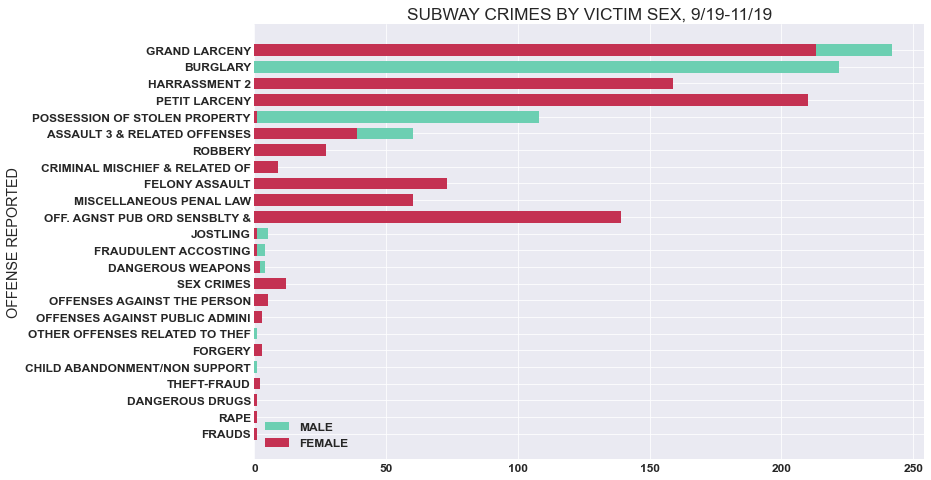

In [330]:
font = {'family':'serif','weight':'bold','size':12}
plt.rc('font', **font)
width = .7
with plt.style.context('seaborn-darkgrid'):
    f = plt.figure() 
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 8)
    plt.gca().invert_yaxis()
    ax.barh(comp_2019[comp_2019.vic_sex == 'M']['ofns_desc'].unique(), comp_2019[comp_2019.vic_sex == 'M']['ofns_desc'].value_counts(), width, label='MALE', color="#6ccfb2")
    ax.barh(comp_2019[comp_2019.vic_sex == 'F']['ofns_desc'].unique(), comp_2019[comp_2019.vic_sex == 'F']['ofns_desc'].value_counts(), width, label='FEMALE', color="#c43152")

    ax.set_ylabel('OFFENSE REPORTED')
    ax.set_title('SUBWAY CRIMES BY VICTIM SEX, 9/19-11/19')
    ax.legend()

    plt.show()

We'll filter out the offenses that aren't committed particularly against women, like burglary, later on. For now, let's look at the unique station names for the complaints dataset, to figure out how to match up those names with the turnstiles dataset as much as possible.

In [149]:
comp_station_array = comp_2019['station'].unique()

In [150]:
comp_station_array.sort()
comp_station_array


array(['1 AV', '102 ST', '103 ST', '103 ST-CORONA PLAZA', '104 ST',
       '110 ST', '110 ST-CATHEDRAL PKWY', '110 ST-CENTRAL PARK NORTH',
       '111 ST', '116 ST', '116 ST-COLUMBIA UNIVERSITY', '121 ST',
       '125 ST', '135 ST', '137 ST-CITY COLLEGE',
       '138 ST-GRAND CONCOURSE', '14 ST', '14 ST-UNION SQUARE', '145 ST',
       '148 ST-HARLEM', '149 ST-GRAND CONCOURSE', '15 ST-PROSPECT PARK',
       '155 ST', '157 ST', '161 ST-YANKEE STADIUM', '163 ST-AMSTERDAM AV',
       '167 ST', '168 ST-WASHINGTON HTS', '169 ST', '170 ST',
       '174-175 STS', '175 ST', '176 ST', '179 ST-JAMAICA', '18 AV',
       '18 ST', '181 ST', '182-183 STS', '183 ST', '190 ST', '2 AV',
       '20 AV', '200 ST-DYCKMAN ST', '205 ST-NORWOOD', '207 ST',
       '207 ST-INWOOD', '21 ST', '21 ST-QUEENSBRIDGE', '225 ST',
       '225 ST-MARBLE HILL', '23 ST', '23 ST-ELY AV', '231 ST', '238 ST',
       '238 ST-NEREID AV', '241 ST-WAKEFIELD',
       '242 ST-VAN CORTLANDT PARK', '25 AV', '25 ST', '28 ST', '3 AV',


In [151]:
station_array

array(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST', '111 ST',
       '116 ST', '116 ST-COLUMBIA', '121 ST', '125 ST', '135 ST',
       '137 ST CITY COL', '138/GRAND CONC', '14 ST', '14 ST-UNION SQ',
       '145 ST', '149/GRAND CONC', '14TH STREET', '15 ST-PROSPECT',
       '155 ST', '157 ST', '161/YANKEE STAD', '163 ST-AMSTERDM', '167 ST',
       '168 ST', '169 ST', '170 ST', '174 ST', '174-175 STS', '175 ST',
       '176 ST', '18 AV', '18 ST', '181 ST', '182-183 STS', '183 ST',
       '190 ST', '191 ST', '2 AV', '20 AV', '207 ST', '21 ST',
       '21 ST-QNSBRIDGE', '215 ST', '219 ST', '225 ST', '23 ST', '231 ST',
       '233 ST', '238 ST', '25 AV', '25 ST', '28 ST', '3 AV',
       '3 AV 138 ST', '3 AV-149 ST', '30 AV', '33 ST', '33 ST-RAWSON ST',
       '34 ST-HERALD SQ', '34 ST-HUDSON YD', '34 ST-PENN STA', '36 AV',
       '36 ST', '39 AV', '4 AV-9 ST', '40 ST LOWERY ST',
       '42 ST-BRYANT PK', '42 ST-PORT AUTH', '45 ST', '46 ST',
       '46 ST BLISS ST', '47-50 STS ROCK

How many stations are already matching up, given the replacements we've already done programmatically? Let's make a dictionary to store those.

In [152]:
unique_stations = np.setxor1d(comp_station_array, station_array)
common_stations = list(set(comp_station_array) & set(station_array))

In [153]:
print(len(unique_stations))
unique_stations.sort()
print(unique_stations)
print(len(common_stations))
common_stations.sort()
print(common_stations)

302
['102 ST' '103 ST-CORONA' '103 ST-CORONA PLAZA' '110 ST-CATHEDRAL PKWY'
 '110 ST-CENTRAL PARK NORTH' '116 ST-COLUMBIA'
 '116 ST-COLUMBIA UNIVERSITY' '137 ST CITY COL' '137 ST-CITY COLLEGE'
 '138 ST-GRAND CONCOURSE' '138/GRAND CONC' '14 ST-UNION SQ'
 '14 ST-UNION SQUARE' '148 ST-HARLEM' '149 ST-GRAND CONCOURSE'
 '149/GRAND CONC' '14TH STREET' '15 ST-PROSPECT' '15 ST-PROSPECT PARK'
 '161 ST-YANKEE STADIUM' '161/YANKEE STAD' '163 ST-AMSTERDAM AV'
 '163 ST-AMSTERDM' '168 ST' '168 ST-WASHINGTON HTS' '174 ST'
 '179 ST-JAMAICA' '191 ST' '200 ST-DYCKMAN ST' '205 ST-NORWOOD'
 '207 ST-INWOOD' '21 ST-QNSBRIDGE' '21 ST-QUEENSBRIDGE' '215 ST' '219 ST'
 '225 ST-MARBLE HILL' '23 ST-ELY AV' '233 ST' '238 ST-NEREID AV'
 '241 ST-WAKEFIELD' '242 ST-VAN CORTLANDT PARK' '3 AV 138 ST'
 '3 AV-138 ST' '33 ST-RAWSON ST' '34 ST' '34 ST-HUDSON YD'
 '34 ST-PENN STA' '34 ST-PENN STATION' '36 AV' '39 AV' '40 ST'
 '40 ST LOWERY ST' '42 ST' '42 ST-BRYANT PK' '42 ST-GRAND CENTRAL'
 '42 ST-PORT AUTH' '42 ST-PORT AU

In [154]:
common_dict = {}
for i in range(len(common_stations)):
    common_dict[common_stations[i]] = common_stations[i]
print(common_dict)

{'1 AV': '1 AV', '103 ST': '103 ST', '104 ST': '104 ST', '110 ST': '110 ST', '111 ST': '111 ST', '116 ST': '116 ST', '121 ST': '121 ST', '125 ST': '125 ST', '135 ST': '135 ST', '14 ST': '14 ST', '145 ST': '145 ST', '155 ST': '155 ST', '157 ST': '157 ST', '167 ST': '167 ST', '169 ST': '169 ST', '170 ST': '170 ST', '174-175 STS': '174-175 STS', '175 ST': '175 ST', '176 ST': '176 ST', '18 AV': '18 AV', '18 ST': '18 ST', '181 ST': '181 ST', '182-183 STS': '182-183 STS', '183 ST': '183 ST', '190 ST': '190 ST', '2 AV': '2 AV', '20 AV': '20 AV', '207 ST': '207 ST', '21 ST': '21 ST', '225 ST': '225 ST', '23 ST': '23 ST', '231 ST': '231 ST', '238 ST': '238 ST', '25 AV': '25 AV', '25 ST': '25 ST', '28 ST': '28 ST', '3 AV': '3 AV', '3 AV-149 ST': '3 AV-149 ST', '30 AV': '30 AV', '33 ST': '33 ST', '34 ST-HERALD SQ': '34 ST-HERALD SQ', '36 ST': '36 ST', '4 AV-9 ST': '4 AV-9 ST', '45 ST': '45 ST', '46 ST': '46 ST', '49 ST': '49 ST', '5 AV': '5 AV', '50 ST': '50 ST', '51 ST': '51 ST', '53 ST': '53 ST

Below I'm manually assembling a dictionary to modify station names that need it, after comparing the two station name arrays. I don't want to also manually enter all the names that are already correct in *one* dataset, so I'm also creating a dictionary that will store those key/value pairs that don't need modification. Then, I'm adding all three dictionaries together so I can use it to map station names across both datasets.

In [155]:
station_dict = {'AV "H"':'AV H', 
                'AV "I"':'AV I',
                'AV "J"':'AV J',  
                'AV "M"':'AV M', 
                'AV "N"':'AV N',
                'AV "P"':'AV P',
                'AV "U"':'AV U',
                'AV "X"':'AV X', 
                'ATL AV-BARCLAY': 'ATLANTIC AV',           
                '103 ST-CORONA':'103 ST-CORONA PLAZA',
                '103 ST-CORONA PLAZA':'103 ST-CORONA PLAZA',
                'CATHEDRAL PKWY':'110 ST-CATHEDRAL PKWY', 
                'CENTRAL PK N110':'110 ST-CENTRAL PARK NORTH',               
                '116 ST-COLUMBIA':'116 ST-COLUMBIA UNIVERSITY',
                '116 ST-COLUMBIA UNIVERSITY':'116 ST-COLUMBIA UNIVERSITY',
                '137 ST CITY COL':'137 ST-CITY COLLEGE', 
                '137 ST-CITY COLLEGE':'137 ST-CITY COLLEGE',
                '138/GRAND CONC':'138 ST-GRAND CONCOURSE',
                '138 ST-GRAND CONCOURSE':'138 ST-GRAND CONCOURSE',
                '14 ST-UNION SQ':'14 ST-UNION SQUARE', 
                'UNION SQUARE':'14 ST-UNION SQUARE',
                '15 ST-PROSPECT':'15 ST-PROSPECT PARK',
                'HARLEM 148 ST':'148 ST-HARLEM',
                '149/GRAND CONC':'149 ST-GRAND CONCOURSE',
                '14TH STREET':'14 ST',
                '15 ST-PROSPECT':'15 ST-PROSPECT PARK',
                '161/YANKEE STAD':'161 ST-YANKEE STADIUM',
                '163 ST-AMSTERDM':'163 ST-AMSTERDAM AV',
                '168 ST-WASHINGTON HTS':'168 ST',
                'JAMAICA 179 ST':'179 ST-JAMAICA',
                'DYCKMAN ST':'200 ST-DYCKMAN ST',
                'NORWOOD 205 ST':'205 ST-NORWOOD',
                'INWOOD-207 ST':'207 ST-INWOOD',
                '21 ST-QNSBRIDGE':'21 ST-QUEENSBRIDGE',
                'MARBLE HILL-225':'225 ST-MARBLE HILL',
                'NEREID AV':'238 ST-NEREID AV', 
                'WAKEFIELD/241':'241 ST-WAKEFIELD',
                'V.CORTLANDT PK':'242 ST-VAN CORTLANDT PARK',
                'VCORTLANDT PK':'242 ST-VAN CORTLANDT PARK',
                '3 AV 138 ST':'3 AV-138 ST',
                'WEST 34 ST/HUDSON YARDS':'34 ST-HUDSON YD',
                '34 ST-PENN STA':'34 ST-PENN STATION', 
                '40 ST LOWERY ST':'40 ST',
                '42 ST':'42 ST-BRYANT PK',
                'GRD CNTRL-42 ST':'42 ST-GRAND CENTRAL',
                '42 ST-PORT AUTHORITY BUS TERM':'42 ST-PORT AUTH',
                'TIMES SQ-42 ST':'42 ST-TIMES SQUARE',
                '47-50 STS ROCK':'47-50 STS/ROCKEFELLER CTR',
                '59 ST COLUMBUS':'59 ST-COLUMBUS CIRCLE',
                '61 ST WOODSIDE':'61 ST-WOODSIDE',
                '63 DRIVE-REGO PARK':'63 DR-REGO PARK',
                '66 ST-LINCOLN':'66 ST-LINCOLN CENTER',
                '68ST-HUNTER CO':'68 ST-HUNTER COLLEGE',
                '72ND ST':'72 ST',
                '75 ST-ELDERTS':'75 ST-ELDERTS LANE',
                '7TH AV':'7 AV',
                '81 ST-MUSEUM OF NATURAL HISTO':'81 ST-MUSEUM',
                '82 ST-JACKSON H':'82 ST-JACKSON HEIGHTS',
                '85 ST-FOREST PK':'85 ST-FOREST PKWY',
                '86TH ST':'86 ST-2 AV',
                '90 ST-ELMHURST':'90 ST-ELMHURST AV',                
                '96TH ST':'96 ST-2 AV',
                '9TH ST':'9 ST',
                '9TH STREET':'9 ST',
                'AQUEDUCT NCOND': 'AQUEDUCT-NORTH CONDUIT AV',
                'AQUEDUCT RACETR':'AQUEDUCT-RACETRACK', 
                'ASTOR PL':'ASTOR PLACE',
                'BAY PARKWAY':'BAY PKWY',
                'BEDFORD-NOSTRAN':'BEDFORD-NOSTRAND AVS',
                'BRDWAY-EAST NEW YORK':'BROADWAY-EAST NEW YORK',
                'BROADWAY JCT':'BROADWAY',                
                "B'WAY-LAFAYETTE":'BROADWAY/LAFAYETTE',
                'BROOKLYN BRIDGE':'BROOKLYN BRIDGE-CITY HALL',
                'BUSHWICK AV':'BUSHWICK AV-ABERDEEN ST',
                'CHRISTOPHER ST':'CHRISTOPHER ST-SHERIDAN SQ',
                'CLINTON-WASH AV':'CLINTON-WASHINGTON AVS',
                'CONEY IS-STILLW':'STILLWELL AV-CONEY ISLAND',
                'COURT SQ':'COURT SQUARE',
                'DELANCEY/ESSEX':'DELANCEY ST',
                "EAST 143 ST-ST MARY'S ST":"E 143/ST MARY'S",
                'EAST 149 ST':'E 149 ST',
                'EAST 180 ST':'E 180 ET',
                'EASTN PKWY-MUSM':'EASTERN PKWY-BROOKLYN MUSEUM',
                'FAR ROCKAWAY':'FAR ROCKAWAY-MOTT AV',
                'FLATBUSH AV-BROOKLYN COLLEGE':'FLATBUSH AV-BC',
                'FT HAMILTON PKY':'FORT HAMILTON PKWY',
                'GRAND ARMY PLAZ':'GRAND ARMY PLAZA',
                'GRAND-NEWTOWN':'GRAND AV-NEWTON',
                'HOWARD BCH JFK':'HOWARD BEACH-JFK AIRPORT',
                'HOYT-SCHER':'HOYT-SCHERMERHORN',
                'HUNTERS POINT AV':'HUNTERS PT AV', 
                'JAMAICA VAN WK':'JAMAICA-VAN WYCK',
                'JAY ST-BOROUGH HALL':'BOROUGH HALL',
                'KINGS HIGHWAY':'KINGS HWY',
                'KINGSTON-THROOP':'KINGSTON-THROOP AVS',
                'KNICKERBOCKER':'KNICKERBOCKER AV',
                'KOSCIUSKO ST':'KOSCIUSZKO ST',
                'MYRTLE-WILLOUGH':'MYRTLE-WILLOUGHBY AVS',
                'MYRTLE-WYCKOFF':'MYRTLE/WYCKOFF AVS',
                'PARSONS/ARCHER-JAMAICA CENTER':'JAMAICA CENTER',
                'PATH NEW WTC':'PATH WTC 2',
                'QUEENSBORO PLAZA':'QUEENSBORO PLZ',
                'ROOSEVELT ISLND':'ROOSEVELT ISLAND',
                'SMITH-9 STS':'SMITH-9 ST',
                'MORISN AV/SNDVW':'SOUNDVIEW AV',
                'SUTPHIN-ARCHER': 'SUTPHIN BLVD-ARCHER AV',
                'SUTTER AV-RUTLD':'SUTTER AV-RUTLAND RD',
                'THIRTY ST':'30 ST',
                'THIRTY THIRD ST':'33 ST',
                'TWENTY THIRD ST':'23 ST',
                'CROWN HTS-UTICA':'UTICA AV-CROWN HEIGHTS',
                'VAN WYCK BLVD-BRIARWOOD':'BRIARWOOD',
                'VERNON-JACKSON':'VERNON BLVD-JACKSON AV',
                'W 4 ST':'W 4 ST-WASH SQ',
                'W 8 ST-AQUARIUM':'WEST 8 ST-NY AQUARIUM',
                'WAKEFIELD/241':'241 ST-WAKEFIELD',   
                'WEST FARMS SQ':'EAST TREMONT AV-WEST FARMS S',
                'WESTCHESTER SQ':'EAST TREMONT AV-WESTCHESTER S',
                'WHITEHALL S-FRY':'WHITEHALL ST-SOUTH FERRY',
                'METS-WILLETS PT':'WILLETS POINT-SHEA STADIUM',
                'WOODHAVN BLVD':'WOODHAVEN BLVD',
                'WORLD TRADE CTR':'WTC-CORTLANDT',
                'WYCKOFF AV':'MYRTLE/WYCKOFF AVS'}

In [156]:
new_station_dict = {}
for key,val in station_dict.items():
    new_station_dict[val] = val
print(new_station_dict)

{'AV H': 'AV H', 'AV I': 'AV I', 'AV J': 'AV J', 'AV M': 'AV M', 'AV N': 'AV N', 'AV P': 'AV P', 'AV U': 'AV U', 'AV X': 'AV X', 'ATLANTIC AV': 'ATLANTIC AV', '103 ST-CORONA PLAZA': '103 ST-CORONA PLAZA', '110 ST-CATHEDRAL PKWY': '110 ST-CATHEDRAL PKWY', '110 ST-CENTRAL PARK NORTH': '110 ST-CENTRAL PARK NORTH', '116 ST-COLUMBIA UNIVERSITY': '116 ST-COLUMBIA UNIVERSITY', '137 ST-CITY COLLEGE': '137 ST-CITY COLLEGE', '138 ST-GRAND CONCOURSE': '138 ST-GRAND CONCOURSE', '14 ST-UNION SQUARE': '14 ST-UNION SQUARE', '15 ST-PROSPECT PARK': '15 ST-PROSPECT PARK', '148 ST-HARLEM': '148 ST-HARLEM', '149 ST-GRAND CONCOURSE': '149 ST-GRAND CONCOURSE', '14 ST': '14 ST', '161 ST-YANKEE STADIUM': '161 ST-YANKEE STADIUM', '163 ST-AMSTERDAM AV': '163 ST-AMSTERDAM AV', '168 ST': '168 ST', '179 ST-JAMAICA': '179 ST-JAMAICA', '200 ST-DYCKMAN ST': '200 ST-DYCKMAN ST', '205 ST-NORWOOD': '205 ST-NORWOOD', '207 ST-INWOOD': '207 ST-INWOOD', '21 ST-QUEENSBRIDGE': '21 ST-QUEENSBRIDGE', '225 ST-MARBLE HILL': '225 

In [157]:
station_dict.update(common_dict)
station_dict.update(new_station_dict)
station_dict

{'AV "H"': 'AV H',
 'AV "I"': 'AV I',
 'AV "J"': 'AV J',
 'AV "M"': 'AV M',
 'AV "N"': 'AV N',
 'AV "P"': 'AV P',
 'AV "U"': 'AV U',
 'AV "X"': 'AV X',
 'ATL AV-BARCLAY': 'ATLANTIC AV',
 '103 ST-CORONA': '103 ST-CORONA PLAZA',
 '103 ST-CORONA PLAZA': '103 ST-CORONA PLAZA',
 'CATHEDRAL PKWY': '110 ST-CATHEDRAL PKWY',
 'CENTRAL PK N110': '110 ST-CENTRAL PARK NORTH',
 '116 ST-COLUMBIA': '116 ST-COLUMBIA UNIVERSITY',
 '116 ST-COLUMBIA UNIVERSITY': '116 ST-COLUMBIA UNIVERSITY',
 '137 ST CITY COL': '137 ST-CITY COLLEGE',
 '137 ST-CITY COLLEGE': '137 ST-CITY COLLEGE',
 '138/GRAND CONC': '138 ST-GRAND CONCOURSE',
 '138 ST-GRAND CONCOURSE': '138 ST-GRAND CONCOURSE',
 '14 ST-UNION SQ': '14 ST-UNION SQUARE',
 'UNION SQUARE': '14 ST-UNION SQUARE',
 '15 ST-PROSPECT': '15 ST-PROSPECT PARK',
 'HARLEM 148 ST': '148 ST-HARLEM',
 '149/GRAND CONC': '149 ST-GRAND CONCOURSE',
 '14TH STREET': '14 ST',
 '161/YANKEE STAD': '161 ST-YANKEE STADIUM',
 '163 ST-AMSTERDM': '163 ST-AMSTERDAM AV',
 '168 ST-WASHINGTON

In [158]:
turnstiles_df['station'].value_counts()

34 ST-PENN STA     55231
FULTON ST          52445
23 ST              40033
GRD CNTRL-42 ST    38676
86 ST              34570
                   ...  
GATES AV            1622
CHAUNCEY ST         1617
SUTTER AV           1100
CLEVELAND ST        1092
ORCHARD BEACH        675
Name: station, Length: 377, dtype: int64

In [159]:
turnstiles_df

,c_a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-11-30,03:00:00,REGULAR,7290785,2470635
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-11-30,07:00:00,REGULAR,7290795,2470652
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-11-30,11:00:00,REGULAR,7290860,2470733
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-11-30,15:00:00,REGULAR,7291051,2470808
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-11-30,19:00:00,REGULAR,7291396,2470862
...,...,...,...,...,...,...,...,...,...,...,...
2676228,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-09-06,05:00:00,REGULAR,5554,420
2676229,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-09-06,09:00:00,REGULAR,5554,420
2676230,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-09-06,13:00:00,REGULAR,5554,420
2676231,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2019-09-06,17:00:00,REGULAR,5554,420


In [160]:
comp_w['station'] = comp_w['station'].map(station_dict)
comp_w['station'].value_counts().head(50)

125 ST                       8201
14 ST                        4523
34 ST-PENN STATION           3851
42 ST-PORT AUTH              3734
116 ST                       3356
42 ST-TIMES SQUARE           3151
42 ST-GRAND CENTRAL          3134
14 ST-UNION SQUARE           2465
CANAL ST                     2406
59 ST-COLUMBUS CIRCLE        2330
BOROUGH HALL                 2132
UTICA AV-CROWN HEIGHTS       2058
86 ST                        1850
3 AV-149 ST                  1715
59 ST                        1703
161 ST-YANKEE STADIUM        1639
96 ST                        1558
NOSTRAND AV                  1515
FORDHAM RD                   1513
145 ST                       1502
34 ST-HERALD SQ              1501
JAMAICA CENTER               1497
23 ST                        1443
W 4 ST-WASH SQ               1387
STILLWELL AV-CONEY ISLAND    1264
FRANKLIN AV                  1254
168 ST                       1213
KINGSBRIDGE RD               1184
ATLANTIC AV                  1172
72 ST         

In [161]:
turnstiles_df['station'] = turnstiles_df['station'].map(station_dict)
turnstiles_df['station'].value_counts().head(50)

34 ST-PENN STATION            55231
FULTON ST                     52445
23 ST                         44489
42 ST-GRAND CENTRAL           38676
86 ST                         34570
14 ST                         33500
CANAL ST                      31691
34 ST-HERALD SQ               29715
CHAMBERS ST                   29637
WTC-CORTLANDT                 28960
ATLANTIC AV                   28804
42 ST-PORT AUTH               28016
59 ST                         27822
WALL ST                       27320
42 ST-TIMES SQUARE            26770
PATH WTC 2                    25940
125 ST                        23546
14 ST-UNION SQUARE            22501
59 ST-COLUMBUS CIRCLE         22363
28 ST                         21314
CORTLANDT ST                  21281
33 ST                         21238
96 ST                         20221
161 ST-YANKEE STADIUM         20142
CHURCH AV                     20080
WILLETS POINT-SHEA STADIUM    19998
50 ST                         19799
47-50 STS/ROCKEFELLER CTR   

Now, let's deal with the entries data. Since entries are cumulative, we need to separate out daily entries by looking at the *differences* in entries between each row. Along the way, we'll also look for instances where the counter "resets", so we can remove those and make sure all values are positive and expected.

In [164]:
turnstiles_daily = (turnstiles_df
                        .groupby(["c_a", "unit", "scp", "station", "date"],as_index=False)
                        .entries.first())

In [165]:
turnstiles_daily[["prev_date", "prev_entries"]] = (turnstiles_daily
                                                       .groupby(["c_a", "unit", "scp", "station"])[["date", "entries"]]
                                                       .shift(1))

In [166]:
turnstiles_daily.dropna(subset=["prev_date"], axis=0, inplace=True)

In [341]:
def get_daily_counts(row, max_counter):
    counter = row["entries"] - row["prev_entries"]   
    if counter < 0:
        counter = -counter        
    if counter > max_counter:
        print(f'entries: {row["entries"]} <-- {row["prev_entries"]}')
        counter = min(row["entries"], row["prev_entries"])        
    if counter > max_counter:
        return 0    
    return counter
turnstiles_daily["daily_entries"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

entries: 12 <-- 6170094.0
entries: 505 <-- 3846725.0
entries: 29 <-- 3367892.0
entries: 26 <-- 1084013.0
entries: 871 <-- 2152170.0
entries: 143 <-- 1599329.0
entries: 460787 <-- 6805255.0
entries: 875479593 <-- 775219651.0
entries: 590840 <-- 9156730.0
entries: 107 <-- 2728637.0
entries: 114 <-- 4283137.0
entries: 163 <-- 2209769.0
entries: 134 <-- 1478959.0
entries: 143 <-- 6198009.0
entries: 75 <-- 1121336497.0
entries: 21 <-- 2025847511.0
entries: 1480 <-- 4711918.0
entries: 326 <-- 6844908.0
entries: 222 <-- 6053291.0
entries: 196608 <-- 50345125.0
entries: 589824 <-- 50331648.0
entries: 265 <-- 10392208.0
entries: 2214 <-- 6026439.0
entries: 458752 <-- 117440512.0
entries: 374 <-- 1068534.0
entries: 12 <-- 152964239.0
entries: 2292 <-- 19783215.0
entries: 458752 <-- 117440512.0
entries: 80 <-- 2781090.0
entries: 14 <-- 1841376.0
entries: 2122 <-- 4443513.0
entries: 4982314 <-- 877275.0
entries: 1440 <-- 2254291.0
entries: 721441481 <-- 2880437.0
entries: 14 <-- 4584481.0
entries:

In [168]:
station_daily = turnstiles_daily.groupby(["station", "date"])[['daily_entries']].sum().reset_index()
station_daily.head()

,station,date,daily_entries
0,1 AV,2019-09-02,4169.0
1,1 AV,2019-09-03,3657.0
2,1 AV,2019-09-04,15620.0
3,1 AV,2019-09-05,16739.0
4,1 AV,2019-09-06,18923.0


In [171]:
station_totals = station_daily.groupby('station')['daily_entries'].sum() \
    .reset_index() \
    .sort_values('daily_entries', ascending=False)

station_totals.head()

,station,daily_entries
66,34 ST-PENN STATION,13268516.0
71,42 ST-GRAND CENTRAL,12463012.0
49,23 ST,11213115.0
64,34 ST-HERALD SQ,9972776.0
72,42 ST-PORT AUTH,8333713.0


Let's make a column that will log each complaint as '1' so we can use it for summing.

In [172]:
comp_w['complaint_counts'] = 1
comp_s_sum = comp_w.groupby('station')[['complaint_counts']].sum().reset_index()
comp_s_sum

,station,complaint_counts
0,1 AV,415
1,103 ST,1039
2,103 ST-CORONA PLAZA,443
3,104 ST,65
4,110 ST,901
...,...,...
300,WILSON AV,172
301,WINTHROP ST,191
302,WOODHAVEN BLVD,326
303,WOODLAWN,384


Merging the datasets, finally!

In [173]:
merged_df = pd.merge(comp_s_sum,station_totals,on='station')
merged_df

,station,complaint_counts,daily_entries
0,1 AV,415,1298502.0
1,103 ST,1039,2420919.0
2,103 ST-CORONA PLAZA,443,1659535.0
3,104 ST,65,332039.0
4,110 ST,901,860929.0
...,...,...,...
298,WILSON AV,172,334003.0
299,WINTHROP ST,191,547041.0
300,WOODHAVEN BLVD,326,1998177.0
301,WOODLAWN,384,548572.0


Let's visualize the data to see what kind of correlation there is between traffic and complaint numbers.

Text(0, 0.5, 'Charges of assault, rape, harrassment filed')

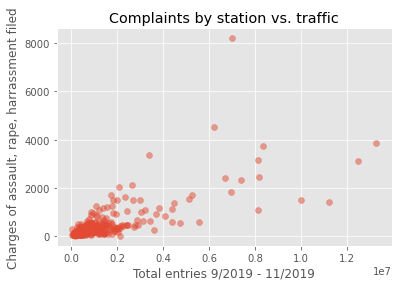

In [174]:
plt.style.use('ggplot')
plt.scatter(merged_df['daily_entries'],merged_df['complaint_counts'],alpha=.5);
plt.title('Complaints by station vs. traffic')
plt.xlabel('Total entries 9/2019 - 11/2019')
plt.ylabel('Charges of assault, rape, harrassment filed')

In [175]:
merged_df.describe()

,complaint_counts,daily_entries
count,303.000000,3.030000e+02
mean,487.841584,1.371140e+06
std,767.247882,1.898023e+06
min,19.000000,2.417100e+04
25%,150.000000,3.770390e+05
50%,244.000000,6.914840e+05
75%,487.500000,1.480329e+06
max,8201.000000,1.326852e+07


In [176]:
corr = merged_df.corr()
corr

,complaint_counts,daily_entries
complaint_counts,1.000000,0.725618
daily_entries,0.725618,1.000000


.73 is a pretty strong correlation. Clearly traffic is the main factor driving complaint numbers, but it isn't the whole story. Let's create a metric that we can use to evaluate complaints given traffic. I'm dividing total complaints by total entries for each station, and multiplying by 100 to get a percentage. We can think of it as: "For every 100 people entering a station, how many sex-related charges are filed?"

In [177]:
merged_df['percentage'] = merged_df['complaint_counts'] / merged_df['daily_entries'] * 100

Now we can take our first look at the most dangerous stations.

In [178]:
sorted_df = merged_df.sort_values('percentage', ascending=False)
sorted_df

,station,complaint_counts,daily_entries,percentage
149,BROAD CHANNEL,293,24171.0,1.212196
94,74 ST-BROADWAY,495,280012.0,0.176778
135,BEACH 98 ST,58,36679.0,0.158129
285,SUTTER AV,395,263259.0,0.150042
180,E 143/ST MARY'S,123,88768.0,0.138563
...,...,...,...,...
294,WALL ST,267,3599243.0,0.007418
61,30 AV,101,1440802.0,0.007010
64,34 ST-HUDSON YD,94,1777972.0,0.005287
111,96 ST-2 AV,81,1589481.0,0.005096


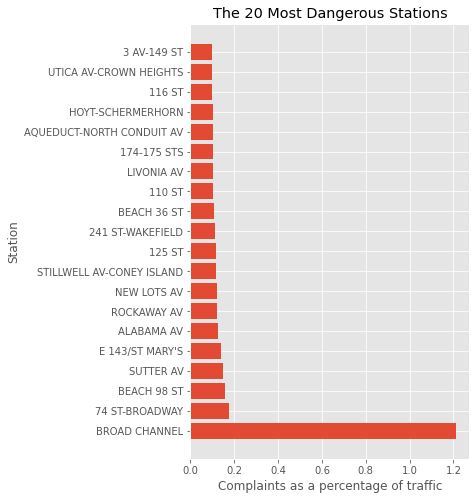

In [286]:
fig = plt.figure(figsize=(5, 8))
plt.xlabel('Complaints as a percentage of traffic')
plt.ylabel('Station')
plt.title('The 20 Most Dangerous Stations')
plt.barh(sorted_df['station'].head(20), sorted_df['percentage'].head(20))
plt.show;

In [180]:
sorted_df.describe()

,complaint_counts,daily_entries,percentage
count,303.000000,3.030000e+02,303.000000
mean,487.841584,1.371140e+06,0.048572
std,767.247882,1.898023e+06,0.073430
min,19.000000,2.417100e+04,0.001640
25%,150.000000,3.770390e+05,0.020299
50%,244.000000,6.914840e+05,0.036637
75%,487.500000,1.480329e+06,0.062310
max,8201.000000,1.326852e+07,1.212196


Let's make a scatterplot along with a line of best fit so we can really visualize the trend.

In [181]:
std = 0.073430
mean = 0.048572

In [182]:
m, b = np.polyfit(merged_df['daily_entries'],merged_df['complaint_counts'],1)
print(m)
print(b)

0.0002933201829072079
85.65847886718147


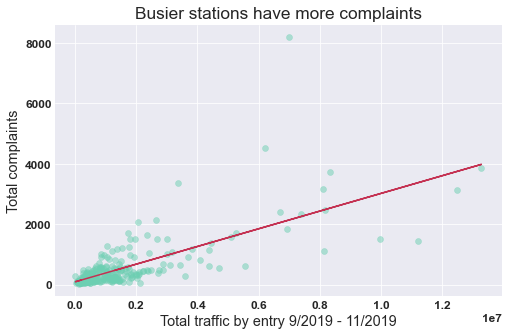

In [311]:
font = {'family':'serif','weight':'bold','size':12}

plt.rc('font', **font)
x = merged_df['daily_entries']
y = merged_df['complaint_counts']
with plt.style.context('seaborn-darkgrid'):
    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(5)
    plt.xlabel('Total traffic by entry 9/2019 - 11/2019')
    plt.ylabel('Total complaints')
    plt.title('Busier stations have more complaints')
    plt.scatter(x,y,alpha=.5,color='#6ccfb2');  
    plt.plot(x,m*x+b,color='#c43152')
    plt.show()

How confident are we that the stations that seem "dangerous" aren't due to random variation? Let's see which stations are more than two standard deviations from the mean. 

In [185]:
mask = merged_df['percentage'] > (mean + 2*std)
merged_df[mask]


,station,complaint_counts,daily_entries,percentage
149,BROAD CHANNEL,293,24171.0,1.212196


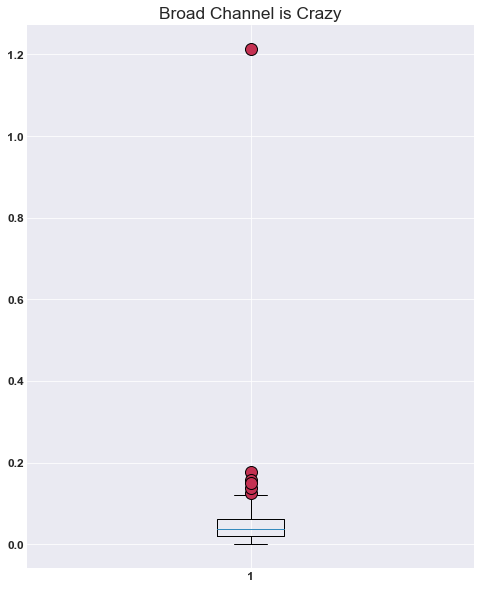

In [317]:
with plt.style.context('seaborn-darkgrid'):
    f = plt.figure()
    f.set_figwidth(8)
    f.set_figheight(10)
    flierprops = dict(marker='o', markerfacecolor='#c43152', markersize=12,
                  linestyle='none')
    plt.boxplot(merged_df['percentage'],flierprops=flierprops)
    plt.title('Broad Channel is Crazy')
    plt.show()

Oof, Broad Channel looks way more dangerous than any other station - it's a true outlier. There's no problem with the source data - this result occurs in all the date ranges I tested, and their entry data and complaint data don't have significant issues. What's more, this station is known to have the highest percentage of crimes relative to traffic since at least 2014: https://www.nydailynews.com/new-york/nyc-crime/daily-news-analysis-reveals-crime-rankings-city-subway-system-article-1.1836918 

However, there's a strong reason to believe it's not so bad as it looks. The station is most widely known as a transfer point to the beaches, and the data doesn't track transfers - only entries and exits. Since Broad Channel is in such an underpopulated area, it makes sense that their results will appear to be off the charts. Their number of complaints is probably more proportionate when one takes transfer volume into account. Unfortunately, there's no way to access transfer data, so all we can do is keep this factor in mind.

Let's see what happens to our data if we remove Broad Channel, since it's skewing the distribution.

In [186]:
no_outliers = merged_df[merged_df.station != "BROAD CHANNEL"]
no_outliers.describe()

,complaint_counts,daily_entries,percentage
count,302.000000,3.020000e+02,302.000000
mean,488.486755,1.375600e+06,0.044719
std,768.438991,1.899582e+06,0.029942
min,19.000000,3.667900e+04,0.001640
25%,149.500000,3.852138e+05,0.020295
50%,241.500000,6.935745e+05,0.036620
75%,488.250000,1.481974e+06,0.062052
max,8201.000000,1.326852e+07,0.176778


In [188]:
std2 = 0.029942
mean2 = 0.044719
mask2 = no_outliers['percentage'] > (mean2 + 2*std2)
no_outliers[mask2].sort_values('percentage', ascending=False)

,station,complaint_counts,daily_entries,percentage
94,74 ST-BROADWAY,495,280012.0,0.176778
135,BEACH 98 ST,58,36679.0,0.158129
285,SUTTER AV,395,263259.0,0.150042
180,E 143/ST MARY'S,123,88768.0,0.138563
112,ALABAMA AV,213,169717.0,0.125503
269,ROCKAWAY AV,1024,848520.0,0.120681
250,NEW LOTS AV,518,435269.0,0.119007
282,STILLWELL AV-CONEY ISLAND,1264,1065823.0,0.118594
11,125 ST,8201,6979593.0,0.117500
53,241 ST-WAKEFIELD,392,351057.0,0.111663


This is more useful - there's now a longer list of stations that are dangerous in a statistically significant way. Let's call all stations above .104% "very dangerous". (The mean, as you can see, is .045).

In [324]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x = merged_df[merged_df.percentage > .104]['daily_entries'],
    y = merged_df[merged_df.percentage > .104]['complaint_counts'],
    name = 'Very dangerous',
    mode = 'markers',
    marker = dict(
        size=10,
        color='#c43152',
        line=dict(width=1)
    ),
    text=merged_df['station'],)
)

fig.add_trace(go.Scatter(
    x = merged_df[(merged_df.percentage >= .062) & (merged_df.percentage <= .104)]['daily_entries'],
    y = merged_df[(merged_df.percentage >= .062) & (merged_df.percentage <= .104)]['complaint_counts'],
    name = 'Dangerous',
    mode = 'markers',
    marker = dict(
        size=8,
        color='#715a99',
        line=dict(width=1)
    ),
    text=merged_df['station'],)
)
fig.add_trace(go.Scatter(
    x = merged_df[(merged_df.percentage >= .02) & (merged_df.percentage < .065)]['daily_entries'],
    y = merged_df[(merged_df.percentage >= .02) & (merged_df.percentage < .065)]['complaint_counts'],
    name = 'Normal',
    mode = 'markers',
    marker = dict(
        size=5,
        color='lightgray',
        line=dict(width=1)
    ),
    text=merged_df['station'],)
)              
fig.add_trace(go.Scatter(
    x = merged_df[merged_df.percentage < .02]['daily_entries'],
    y = merged_df[merged_df.percentage < .02]['complaint_counts'],
    name = 'Relatively safe',
    mode = 'markers',
    marker = dict(
        size=5,
        color='#6ccfb2',
        opacity=0.5,
        line=dict(width=1)
    ),
    text=merged_df['station'],)
)

fig.update_layout(
    template = 'simple_white',
    title = 'How safe is each MTA station?',
    xaxis = dict(
        title = 'Station traffic 9/2019 - 11/2019',
        zeroline = False
    ),
    yaxis = dict(
        title = 'Complaints',
        hoverformat = '.1f',
        zeroline = False
    ),
    hovermode= 'closest'
)

fig.show()

In [190]:
merged_df.sort_values(['percentage'],ascending=False).head(20)

,station,complaint_counts,daily_entries,percentage
149,BROAD CHANNEL,293,24171.0,1.212196
94,74 ST-BROADWAY,495,280012.0,0.176778
135,BEACH 98 ST,58,36679.0,0.158129
285,SUTTER AV,395,263259.0,0.150042
180,E 143/ST MARY'S,123,88768.0,0.138563
112,ALABAMA AV,213,169717.0,0.125503
269,ROCKAWAY AV,1024,848520.0,0.120681
250,NEW LOTS AV,518,435269.0,0.119007
282,STILLWELL AV-CONEY ISLAND,1264,1065823.0,0.118594
11,125 ST,8201,6979593.0,0.117500


Now, let's filter for female victim sex, as well as offenses involving sex crimes, assault, and harassment. We can compare results with the larger dataset with all offenses. I'm multiplying entry data by .52, since 52% of NYC subway riders are women. This makes the percentage field more intuitive to interpret.

In [360]:
fem_df = comp_w[comp_w['vic_sex'] == 'F']
offense_mask = (fem_df['ofns_desc'] == 'HARRASSMENT')|(fem_df['ofns_desc'] == 'SEX CRIMES')|(fem_df['ofns_desc'] == 'ASSAULT 3 & RELATED OFFENSES')|(fem_df['ofns_desc'] == 'FELONY ASSAULT')|(fem_df['ofns_desc'] == 'RAPE')|(fem_df['ofns_desc'] == 'OFFENSES AGAINST THE PERSON')
fem_df = fem_df[offense_mask].copy()
fem_df['complaint_counts'] = 1
fem_df = fem_df.groupby('station')[['complaint_counts']].sum().reset_index()
f_merged_df = pd.merge(fem_df,station_totals,on='station')
f_merged_df['daily_entries'] = f_merged_df['daily_entries'] *.52
f_merged_df['percentage'] = f_merged_df['complaint_counts'] / f_merged_df['daily_entries'] * 100
f_sorted_df = f_merged_df.sort_values('percentage', ascending=False)
f_sorted_df.head(20)

,station,complaint_counts,daily_entries,percentage
6,BROAD CHANNEL,24,12568.92,0.190947
2,BOTANIC GARDEN,29,150852.52,0.019224
18,HOYT-SCHERMERHORN,92,500911.32,0.018367
9,BROOKLYN BRIDGE-CITY HALL,133,782192.84,0.017003
25,QUEENS PLAZA,89,613784.60,0.014500
24,PROSPECT PARK,42,440048.44,0.009544
14,EASTERN PKWY-BROOKLYN MUSEUM,16,169055.64,0.009464
22,PARK PLACE,17,187788.12,0.009053
12,CYPRESS HILLS,5,60180.12,0.008308
19,JAMAICA-VAN WYCK,14,183597.96,0.007625


<BarContainer object of 5 artists>

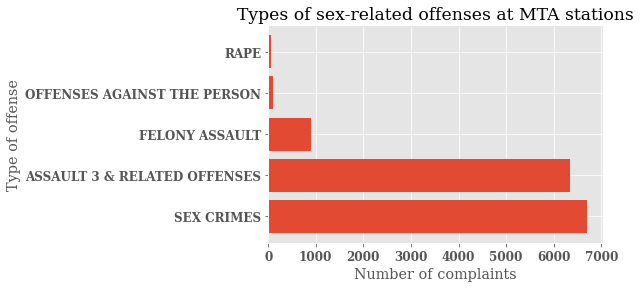

In [361]:
plt.title('Types of sex-related offenses at MTA stations')
plt.xlabel('Number of complaints')
plt.ylabel('Type of offense')
plt.barh(comp_sex_offense['ofns_desc'].unique(),comp_sex_offense['ofns_desc'].value_counts())

In [322]:
dangerous_data = (f_sorted_df.percentage > .013)
y = round(f_sorted_df[dangerous_data]['percentage']*100)
x = list(f_sorted_df[dangerous_data]['station'])
y_2 = round(sorted_df[sorted_df.station.isin(x)]['percentage']*100)

fig = go.Figure(data=[
    go.Bar(name='Sex-related offenses against women', x=y, y=x, orientation='h',marker_color="#c43152"),
    go.Bar(name='Total offenses', x=y_2, y=x, orientation='h',marker_color="#6ccfb2")
],layout=go.Layout(title=go.layout.Title(text="The Most Dangerous Subway Stations"),xaxis = dict(
      title="Complaints per thousand subway entries")))
                
fig.update_layout(barmode='group')
fig.show()

There is very little difference, station by station, between sex-related crimes against women and crimes reported generally; as one category increases, the other does as well, in direct proportion. Broad Channel is the exception. Both categories are unusually bad, but the proportion of sex-related crimes is lower. Let's see what kinds of crimes are being reported there.

In [275]:
broad_df = comp_w[comp_w.station == "BROAD CHANNEL"][['ofns_desc']].copy()
broad_df['count'] = 1
broad_offenses = broad_df.groupby('ofns_desc').sum('count').sort_values('count', ascending=False).reset_index()
broad_offenses

,ofns_desc,count
0,CRIMINAL MISCHIEF & RELATED OF,51
1,ASSAULT 3 & RELATED OFFENSES,30
2,GRAND LARCENY,27
3,DANGEROUS WEAPONS,26
4,OFFENSES AGAINST PUBLIC ADMINI,26
5,PETIT LARCENY,25
6,HARRASSMENT 2,24
7,DANGEROUS DRUGS,17
8,FELONY ASSAULT,16
9,ROBBERY,14


In [323]:
x = list(broad_offenses.ofns_desc)
y = list(broad_offenses['count'])

fig = go.Figure(data=[
    go.Bar(x=x, y=y,marker_color='#639fc0'),
],layout=go.Layout(title=go.layout.Title(text="What's happening at Broad Channel?"),xaxis = dict(
      title="Offense descriptions"),yaxis = dict(
      title="Number of complaints 9/19 - 11/19")))
                
fig.update_layout(barmode='group')
fig.show()

We'll be able to see what's going on more easily without Broad Station.

In [325]:
dangerous_data = (f_sorted_df.percentage > .013)&(f_sorted_df.percentage < .1)
y = round(f_sorted_df[dangerous_data]['percentage']*100)
x = list(f_sorted_df[dangerous_data]['station'])
y_2 = sorted_df[sorted_df.station.isin(x)]['percentage']*100

fig = go.Figure(data=[
    go.Bar(name='Sex-related offenses against women', x=y, y=x, orientation='h',marker_color="#c43152"),
    go.Bar(name='Total offenses', x=y_2, y=x, orientation='h',marker_color="#6ccfb2")
],layout=go.Layout(title=go.layout.Title(text="The Most Dangerous Subway Stations"),xaxis = dict(
      title="Complaints per thousand subway entries")))
                
fig.update_layout(barmode='group')
fig.show()

Just for fun, let's see how the stations would be ranked if we were only looking at raw complaint numbers, without factoring in traffic. (It's about what you'd expect!)

In [547]:
merged_df.sort_values(['complaint_counts'],ascending=False).head(20)

,station,complaint_counts,daily_entries,percentage
30,42 ST-GRAND CENTRAL,1125,12463012.0,0.009027
6,14 ST,752,6203183.0,0.012123
32,42 ST-TIMES SQUARE,393,8106409.0,0.004848
40,72 ST,299,4373026.0,0.006837
7,14 ST-UNION SQUARE,263,8168533.0,0.003220
34,59 ST-COLUMBUS CIRCLE,247,7392924.0,0.003341
61,BOROUGH HALL,187,2650800.0,0.007054
9,149 ST-GRAND CONCOURSE,176,1058499.0,0.016627
27,34 ST-PENN STATION,175,13268516.0,0.001319
31,42 ST-PORT AUTH,162,8333713.0,0.001944
